In [1]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
import numpy as np
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import csv

### Set model parameters

In [2]:
# inputs
bs = 100
img_size = 28

# Conv2d parameters
cp_inchannel = 1
cp_outchannel = 256
cp_stride = 1
cp_filter = 9

# Primary capsule parameters
pc_inchannel = 256
pc_outchannel = 256
pc_stride = 2
pc_filter = 9

pc_cap_layers = 32
pc_cap_len = 8
pc_size = 6
pc_num_caps = int(pc_size* pc_size * pc_outchannel / pc_cap_len)

# routing
r_iter = 3

# digit caps
dc_len = 16
dc_dim = 10


# loss scale
reconst_loss_scale = 0.0005 * img_size**2  


### Load Data

In [3]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
    ])

In [4]:
train_ds = datasets.MNIST('data', train = True,
                              download = True, transform=transform)
test_ds = datasets.MNIST('data', train = False,
                             download = True, transform=transform)

In [5]:
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True,num_workers=4)
test_loader = DataLoader(test_ds, batch_size=bs, shuffle=False, num_workers=4)

### Visualize data

In [6]:
d = iter(train_loader)
x,y = d.next()
len(x),len(y)

(100, 100)

In [7]:
img_size = x.shape[-1]


In [8]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img*0.3081 +  0.1307
    plt.imshow(np.transpose(img, (1, 2, 0)).squeeze(2), cmap='gray') # convert from Tensor image

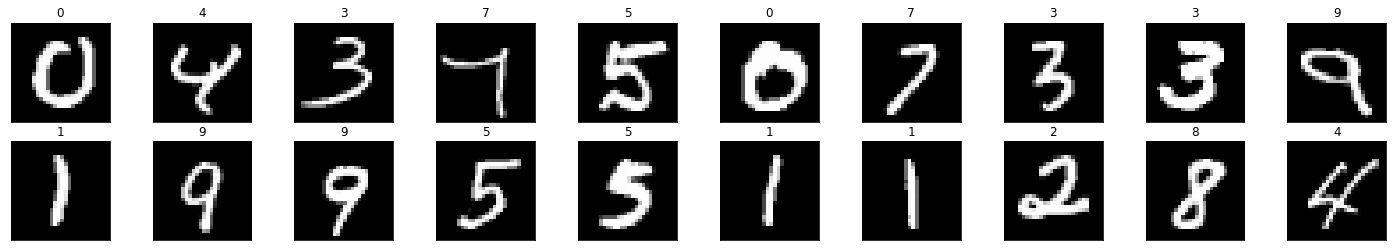

In [9]:
# specify the image classes
classes = ['0','1', '2', '3', '4', '5',
           '6', '7', '8', '9']
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])


### Define model

In [10]:
class CapsNet(nn.Module): 
    def __init__(self, cp_inchannel ,
                    cp_outchannel ,
                    cp_stride ,
                    cp_filter ,
                    pc_inchannel ,
                    pc_outchannel ,
                    pc_stride ,
                    pc_filter ,
                    pc_size, 
                    pc_num_caps, 
                    dc_len,
                    dc_dim,
                    r_iter,
                    reconst_loss_scale,
                    bs):
        super(CapsNet, self).__init__()
        
        self.r_iter = r_iter 
        
        self.conv2d = nn.Conv2d(in_channels=cp_inchannel, out_channels=cp_outchannel, kernel_size=cp_filter, stride=cp_stride)
        self.primary_caps = nn.Conv2d(in_channels=pc_inchannel, out_channels=pc_outchannel, kernel_size=pc_filter, stride=pc_stride)
        self.num_capsules = pc_size* pc_size * pc_outchannel
        self.weights = nn.Parameter(0.01 * torch.randn(1,pc_num_caps,dc_dim,dc_len,pc_cap_len))
        self.reconst_loss_scale = reconst_loss_scale
        self.reconst_loss = nn.MSELoss()

    def forward(self, x):
        conv = self.conv2d(x)
        conv = F.relu(conv)
        pc   = self.primary_caps(conv)
        u    = self.squash(pc.permute(0,2,3,1).contiguous().view(conv.shape[0], -1, pc_cap_len)).unsqueeze(-1).unsqueeze(2)
        u_hat = torch.matmul(self.weights, u).squeeze(4)
        v     = self.routing(u_hat).squeeze(1)
        
        return v
        
    def routing(self, u_hat):
        
        b_ij    = torch.zeros_like(u_hat)
        b_ij = b_ij
        u_route = u_hat.detach()
        for i in range(self.r_iter):
            c_ij = F.softmax(b_ij, dim = 2)
            if i == (self.r_iter - 1):
                s_j = (c_ij*u_hat).sum(dim = 1, keepdim=True)
            else:
                s_j = (c_ij*u_route).sum(dim = 1, keepdim=True)
            
            v_j = self.squash(s_j)
            
            if i < self.r_iter - 1:
                b_ij = b_ij+ (u_route*v_j).sum(3, keepdim = True)
        
        return v_j

               
    def squash(self, s_j):
        s_jnorm = s_j.norm(dim = -1, keepdim = True)
        return s_jnorm / (1. + s_jnorm**2) * s_j
    
    def loss(self, T, v, x_true, x_reconstructed, lambda_param=0.5, m_plus=0.9, m_minus=0.1):     
        v_norm = v.norm(dim=2, keepdim=False)
        return (T*F.relu(m_plus - v_norm)**2 + lambda_param * (1-T)*F.relu(v_norm - m_minus)**2).sum(1).mean() \
                +self.reconst_loss_scale * self.reconst_loss(x_reconstructed, x_true.reshape((100,784)))

In [11]:
class decoder(nn.Module):
    def __init__(self, dc_len, dc_dim, img_size):
        super(decoder, self).__init__()
        self.dc_dim = dc_dim
        self.network = nn.Sequential(
            nn.Linear(dc_dim * dc_len, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, img_size*img_size),
            nn.Sigmoid()
        )

    def forward(self, v, y_ohe):       
        return self.network( (y_ohe[:,:,None] * v).view(v.shape[0], -1) )

In [12]:
model = CapsNet(cp_inchannel ,
                    cp_outchannel ,
                    cp_stride ,
                    cp_filter ,
                    pc_inchannel ,
                    pc_outchannel ,
                    pc_stride ,
                    pc_filter ,
                    pc_size, 
                    pc_num_caps, 
                    dc_len,
                    dc_dim,
                    r_iter,
                    reconst_loss_scale,
                    bs).cuda()

decoder = decoder(dc_len, dc_dim, img_size).cuda()

In [13]:
print(model)
print(decoder)

CapsNet(
  (conv2d): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (primary_caps): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  (reconst_loss): MSELoss()
)
decoder(
  (network): Sequential(
    (0): Linear(in_features=160, out_features=512, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model) + count_parameters(decoder)

8215568

### Learning rate finder to get optimal learning rate

In [15]:
def get_optimizer(model, lr):
    optimiser = torch.optim.Adam(list(model.parameters()) + list(decoder.parameters()),lr = lr)
    return optimiser

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=2):
    losses = []

    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x_train,y_train in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x_train = Variable(x_train.cuda())
            batch = x_train.shape[0]
            y_train_ohe = Variable(torch.eye(10).index_select(dim=0, index=y_train.data).cuda())
            v = model(x_train) 
            # Calculate loss and do backward step
            loss = model.loss(y_train_ohe, v, x_train, decoder(v, y_train_ohe ) ) 
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1     

    return lrs, losses

In [17]:
lrs, losses = LR_range_finder(model, train_loader, lr_low=1e-5, lr_high=1)

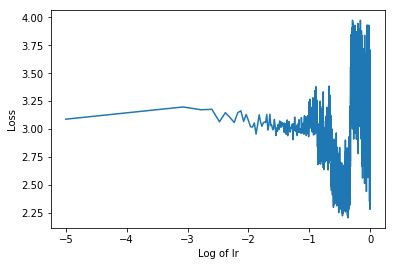

In [20]:
plt.plot([np.log10(l) for l in lrs], losses)
plt.xlabel('Log of lr')
plt.ylabel('Loss')
plt.show()

In [16]:
optimiser = torch.optim.Adam(list(model.parameters()) + list(decoder.parameters()))
#lr_decay = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.96**(1/2000.))

### Set variable to store results

In [18]:
loss_train = 10     # Initialize with arbitrary high value
epoch=0

losses_train = []
losses_test = []

acc_train = []
acc_test = []

min_loss = np.inf

version = '1'
logfile = open('log_'+version+'.csv', 'w')
logwriter = csv.DictWriter(logfile, fieldnames=['epoch', 'train_loss', 'test_loss','accuracy_train', 'accuracy_test'])
logwriter.writeheader()

### Train Model

In [19]:
# Training loop
while True:
    loss_train = 0
    with tqdm(total=len(train_loader)) as pbar:
        model.train()
        accuracy = 0
        for x_train, y_train in train_loader:
          
            # Model training
            x_train = Variable(x_train.cuda())
            batch = x_train.shape[0]
            y_train_ohe = Variable(torch.eye(10).index_select(dim=0, index=y_train.data).cuda())
            
            v = model(x_train) 
            
            # Calculate loss and do backward step
            loss = model.loss(y_train_ohe, v, x_train, decoder(v, y_train_ohe ) ) 
            model.zero_grad()
            decoder.zero_grad()
            loss.backward()
            optimiser.step()  
            
            # Calculates accuracy on batch
            _, y_pred_batch = v.norm(p=2, dim=2).max(dim=1)
            accuracy = accuracy + np.sum(y_pred_batch.data.cpu().numpy() == y_train.cpu().numpy())/batch
            
            # Performance reporting 
            loss_train += loss.item()
            pbar.set_postfix(accuracy_batch=\
                             np.sum(y_pred_batch.data.cpu().numpy() == y_train.cpu().numpy())/batch)
            pbar.update(1)
            #lr_decay.step()
    
    # Loss and accuracy on train set
    loss_train /= len(train_loader)
    accuracy /= len(train_loader)
    acc_train.append(accuracy)

    loss_test_list = []
    accuracy_test = 0
    
    model.eval()
    
    for x_test, y_test in test_loader:
        batch = x_test.shape[0]
        x_test = Variable(x_test.cuda())
        y_test_ohe = Variable(torch.eye(10).index_select(dim=0, index=y_test.data).cuda())
        
        v_test_batch = model(x_test)
        _, y_test_batch = v_test_batch.norm(p=2, dim=2).max(dim=1)
        # Calculates accuracy on batch
        accuracy_test = accuracy_test + np.sum(y_test_batch.data.cpu().numpy() == y_test.cpu().numpy())/batch
        # Loss
        loss_test_list.append( model.loss(y_test_ohe, v_test_batch,\
                                          x_test, decoder(v_test_batch, y_test_ohe)).item())

    

    # Loss and accuracy on validation set
    loss_test = np.mean(loss_test_list)
    accuracy_test = accuracy_test/ len(test_loader)
    acc_test.append(accuracy_test)
 
    # Stores loss values for train and validation
    losses_train.append(loss_train)
    losses_test.append(loss_test)
    
    # Stores model
    if loss_test<min_loss: 
        torch.save(model.state_dict(), 'model_'+version+'.pickle')
        torch.save(decoder.state_dict(), 'decode_'+version+'.pickle')
        min_loss = loss_test
        
    
        
    # Print and log some results
    print(epoch, loss_train, loss_test, min_loss, accuracy)
    logwriter.writerow(dict(epoch=epoch, train_loss=loss_train,
                                test_loss=loss_test, accuracy_train=accuracy, accuracy_test = accuracy_test))

    if epoch ==10:
        break
    epoch += 1

  0%|          | 0/600 [00:00<?, ?it/s]

0 0.3375582300126553 0.2745260924100876 0.2745260924100876 0.9472666666666715


  0%|          | 0/600 [00:00<?, ?it/s]

1 0.2630006825427214 0.25608342736959455 0.25608342736959455 0.9899666666666712


  0%|          | 0/600 [00:00<?, ?it/s]

2 0.24834568463265896 0.24816119492053987 0.24816119492053987 0.9937833333333366


  0%|          | 0/600 [00:00<?, ?it/s]

3 0.23961940887073677 0.24176292940974237 0.24176292940974237 0.9956000000000025


  0%|          | 0/600 [00:00<?, ?it/s]

4 0.23336025709907213 0.23738039761781693 0.23738039761781693 0.9974166666666683


  0%|          | 0/600 [00:00<?, ?it/s]

5 0.22926466343303523 0.23412978693842887 0.23412978693842887 0.998250000000001


  0%|          | 0/600 [00:00<?, ?it/s]

6 0.22613918992380302 0.231625519990921 0.231625519990921 0.9988166666666676


  0%|          | 0/600 [00:00<?, ?it/s]

7 0.22320543420811495 0.2301058651506901 0.2301058651506901 0.999133333333334


  0%|          | 0/600 [00:00<?, ?it/s]

8 0.22060182332992553 0.2275446128845215 0.2275446128845215 0.999516666666667


  0%|          | 0/600 [00:00<?, ?it/s]

9 0.218841089134415 0.22661885678768157 0.22661885678768157 0.999616666666667


100%|██████████| 600/600 [01:41<00:00,  5.97it/s, accuracy_batch=0.99]


10 0.21794323538740476 0.22469991013407709 0.22469991013407709 0.9996333333333337


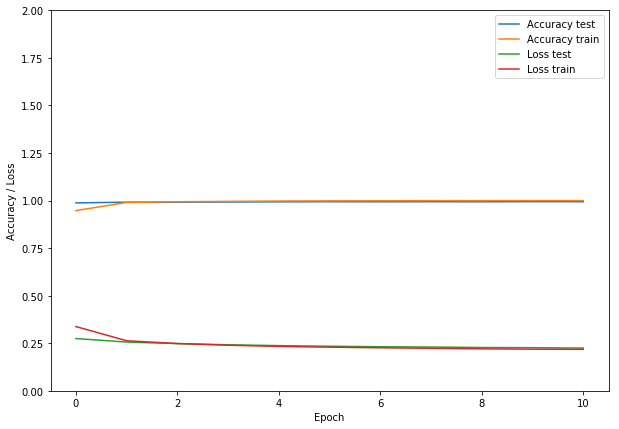

In [23]:
plt.figure(figsize=(10,7))
plt.plot(acc_test, label='Accuracy test')
plt.plot(acc_train, label='Accuracy train')
plt.plot(losses_test, label='Loss test')
plt.plot(losses_train, label='Loss train')
plt.ylabel('Accuracy / Loss')
plt.xlabel('Epoch')
plt.ylim((0,2))

plt.legend()

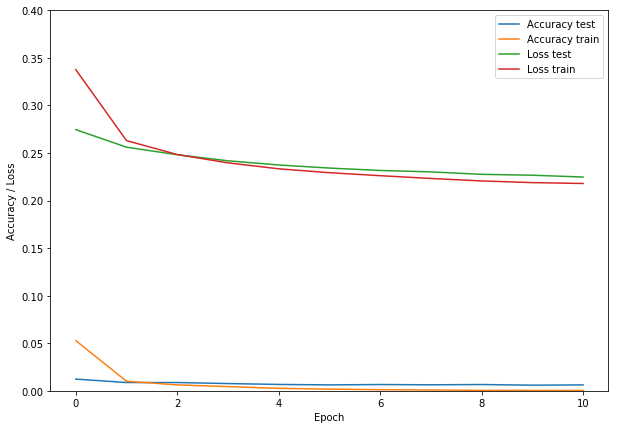

In [26]:
plt.figure(figsize=(10,7))
plt.plot([1-a for a in acc_test], label='Accuracy test')
plt.plot([1-a for a in acc_train], label='Accuracy train')
plt.plot(losses_test, label='Loss test')
plt.plot(losses_train, label='Loss train')
plt.ylabel('Accuracy / Loss')
plt.xlabel('Epoch')
plt.ylim((0,0.4))

plt.legend()



#### Validate Dimensions

In [51]:
classes =((dc_y ** 2).sum(dim=-1) ** 0.5)

In [41]:
classes.shape

torch.Size([256, 10])

In [53]:
classes = F.softmax(classes, dim=-1)

In [56]:
classes

tensor([[0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        ...,
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000]],
       grad_fn=<SoftmaxBackward>)

In [47]:
classes.shape

torch.Size([256, 10])

In [59]:
max_length_indices = classes.max(dim=1)[1]

In [65]:
max_length_indices

tensor([8, 2, 8, 8, 5, 2, 0, 5, 8, 6, 2, 8, 1, 6, 5, 2, 5, 6, 0, 2, 6, 9, 8, 5,
        4, 8, 8, 6, 5, 2, 8, 5, 9, 3, 3, 4, 9, 2, 2, 5, 8, 8, 2, 8, 2, 6, 1, 3,
        2, 8, 1, 5, 8, 9, 6, 1, 9, 9, 6, 8, 6, 2, 3, 3, 4, 8, 4, 9, 3, 5, 5, 0,
        8, 5, 0, 5, 5, 0, 5, 5, 0, 2, 5, 8, 2, 6, 3, 8, 3, 5, 8, 9, 2, 5, 1, 9,
        5, 2, 5, 5, 2, 2, 4, 6, 7, 0, 0, 6, 1, 2, 6, 3, 3, 2, 9, 5, 8, 2, 5, 5,
        3, 0, 5, 2, 9, 8, 8, 5, 5, 5, 8, 9, 1, 5, 4, 5, 5, 1, 8, 9, 8, 6, 8, 1,
        5, 5, 6, 6, 9, 8, 6, 8, 8, 2, 9, 5, 8, 8, 8, 5, 0, 5, 9, 8, 1, 2, 2, 2,
        8, 8, 5, 6, 8, 0, 5, 2, 3, 8, 6, 5, 9, 5, 8, 5, 2, 2, 9, 1, 1, 5, 8, 5,
        2, 3, 2, 6, 2, 4, 6, 3, 1, 2, 3, 8, 9, 5, 2, 2, 6, 3, 8, 9, 5, 7, 4, 5,
        9, 5, 5, 5, 8, 2, 5, 1, 2, 8, 8, 3, 5, 9, 5, 9, 8, 6, 5, 1, 5, 4, 1, 8,
        6, 6, 5, 8, 6, 6, 9, 6, 2, 5, 6, 8, 2, 2, 5, 4])

In [78]:
(dc_y[0]*Variable(torch.eye(10).index_select(dim=0, index=max_length_indices.data))[:,:,None][0])

tensor([[-0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,
          0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000],
        [ 0.0000, -0.0000,  0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,
         -0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000],
        [ 0.0000, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.0000,
         -0.0000,  0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000],
        [ 0.0000,  0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,
         -0.0000, -0.0000,  0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000],
        [ 0.0000, -0.0

In [80]:
dc_y[0].shape

torch.Size([10, 16])

In [95]:
Variable(torch.eye(10).index_select(dim=0, index=y_train.data))[:,:,None][0]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.]])

In [22]:
torch.eye(10).index_select(index = y, dim = 0).unsqueeze(-1)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [18]:
torch.eye(10).index_select(index = y, dim = 0).unsqueeze(-1).shape

torch.Size([256, 10, 1])